In [1]:
!pip install torcheval
!pip install tensorflow==2.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 27.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing install

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Initialize pretrained RoBERTa model and RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', truncation = True)

# Initialize dataset
data = pd.read_csv('drive/MyDrive/RoBERTa_GRU/Sentiment_IMDB_Dataset.csv')
data['sentiment'] = data['sentiment'].map({'positive':1, 'negative':0})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [4]:
# Build custom dataset to feed RoBERTa
class IMDB_Dataset(Dataset):
  def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.reviews = self.data.review
    self.sentiments = self.data.sentiment
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    # Load the review
    text = str(self.reviews[index])

    # Tokenize text and prepare it for model input
    inputs = self.tokenizer.encode_plus(text, None,
                                        truncation=True, padding='max_length',
                                        max_length=self.max_len,
                                        add_special_tokens=True, return_token_type_ids=True)

    ## Prepare data format as expected by RoBERTa model
    # mapping of words into integers according to tokenizer's vocabulary
    ids = inputs['input_ids']

    # Binary mask indicating which tokens are actual input tokens and which are padding tokens
    # The attention mask is used by the model to avoid processing padding tokens, thus saving computational resources and improving performance.
    attention_mask = inputs['attention_mask']

    # IDs are used to distinguish between different sequences in tasks where multiple sequences are
    # provided to the model (e.g., question-answering tasks where there is a context and a question)
    token_type_ids = inputs['token_type_ids']

    return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.sentiments[index], dtype=torch.float)
        }


In [5]:
# Split data between training and testing
training_data = data.sample( frac=0.8 )
testing_data = data.drop(training_data.index).reset_index(drop=True)

training_data = training_data.reset_index(drop=True)

In [6]:
# Save data into custom dataset class
training_set = IMDB_Dataset(data=training_data, tokenizer=tokenizer, max_len=512)
testing_set = IMDB_Dataset(data=testing_data, tokenizer=tokenizer, max_len=512)

print(f"Training data's shape{training_data.shape} - Testing data's shape{testing_data.shape}")

# Initialize data loaders
training_loader = DataLoader(training_set, batch_size=18, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=18, shuffle=True)

Training data's shape(40000, 2) - Testing data's shape(10000, 2)


In [7]:
# Build Model
class RoBERTa_GRU(torch.nn.Module):
  def __init__(self):
    super(RoBERTa_GRU, self).__init__()

    # Initialize the layers that are needed
    self.RoBERTa = RobertaModel.from_pretrained('roberta-base')
    self.gru = torch.nn.GRU( input_size = 768, hidden_size = 256 )
    self.flatten = torch.nn.Flatten()
    self.dense_1 = torch.nn.Linear( in_features = 256, out_features=1000 )
    self.gelu = torch.nn.GELU()
    self.dense_2 = torch.nn.Linear( in_features=1000, out_features=2 )

  def forward(self, input_ids, attention_mask, token_type_ids):

    # Get the last_hidden_states from RoBERTa
    roberta_output = self.RoBERTa(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    # Select the first column from RoBERTa's last_hidden_state output. CLS is the classification of each sequence
    cls = roberta_output.last_hidden_state[:, 0]

    # GRU will learn the longterm dependencies of the sequences
    sequences, gru_hidden_states = self.gru( cls )

    # Doesn't make any difference
    flattened = self.flatten( sequences )

    # Learn relationships between the hidden states
    x = self.dense_1( flattened )
    x = self.gelu(x)

    # Return the prediction
    x = self.dense_2(x)
    output = torch.nn.functional.softmax(x, dim=1)

    return output

In [8]:
# Initialize training components
model = RoBERTa_GRU().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam( params=model.parameters(), lr=0.00001 )

def calculate_accuracy(y_pred, y_true):
    correct = (y_pred == y_true).sum().item()
    return correct

def calculate_metric(y_pred, y_true, metric):
  metric.update(y_pred, y_true)
  score = metric.compute()
  return score

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Model Training
epochs = 2
patience = 15
tolerance = 0.0005

tr_losses = []
tr_accuracies = []
num_steps = 0
nb_tr_examples = 0

# Early Stopping
step_count_without_improvement = 0
loss_tracker = 1000000
best_weights = None

model.train() # Training mode
for epoch in range(epochs):

  for index, data in enumerate(training_loader):
    # Receive data by column + Convert from float to long to match expected dtype for loss_function
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    y_true = data['targets'].to(device, dtype = torch.long)

    # Forward pass
    y_pred = model.forward(ids, mask, token_type_ids)

    # Loss
    loss = loss_function(y_pred, y_true)
    tr_losses.append(loss.item())

    ## Early Stopper after the first epoch
    if epoch >= 1:
      difference = loss_tracker - tolerance
      # if loss  decreases
      if loss.item() < difference:
          print(f"loss_tracker updated at epoch {epoch} batch {index}: {loss_tracker} => {loss.item()}")
          loss_tracker = loss.item()
          step_count_without_improvement = 0
          best_weights = model.state_dict().copy()  # Save the best weights
      else:
          print(f"No Improvement: {loss.item()} >= {difference}. step_count_without_improvement += 1")
          step_count_without_improvement += 1

          # if loss doesn't decrease after n batches
          if step_count_without_improvement >= patience:
              print(f"Early stopping triggered. Batch training stopped.")
              break

    # Accuracy
    max_values, max_indicies = torch.max(y_pred.data, dim=1)
    tr_accuracies.append(calculate_accuracy(max_indicies, y_true))

    # Clear gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()
    optimizer.step()

    # Metrics per batch
    num_steps += 1
    nb_tr_examples += y_true.size(0)

    loss_step = sum(tr_losses) / num_steps
    accu_step = sum(tr_accuracies) / nb_tr_examples
    print(f"Epoch {epoch} => batch {index} => loss: {loss_step:.3f} - accuracy: {accu_step:.3f}")

  # if loss doesn't decrease after n batches, batch training breaks, stop epoch from continuing
  if step_count_without_improvement >= patience:
    print(f"Early stopping triggered. Epoch Stopped")
    if best_weights is not None:
      model.load_state_dict(best_weights)
      print("Best model weights loaded.")
    break

Epoch 0 => batch 0 => loss: 0.700 - accuracy: 0.389
Epoch 0 => batch 1 => loss: 0.704 - accuracy: 0.278
Epoch 0 => batch 2 => loss: 0.700 - accuracy: 0.370
Epoch 0 => batch 3 => loss: 0.698 - accuracy: 0.417
Epoch 0 => batch 4 => loss: 0.696 - accuracy: 0.456
Epoch 0 => batch 5 => loss: 0.696 - accuracy: 0.463
Epoch 0 => batch 6 => loss: 0.696 - accuracy: 0.444
Epoch 0 => batch 7 => loss: 0.696 - accuracy: 0.451
Epoch 0 => batch 8 => loss: 0.695 - accuracy: 0.488
Epoch 0 => batch 9 => loss: 0.695 - accuracy: 0.472
Epoch 0 => batch 10 => loss: 0.695 - accuracy: 0.470
Epoch 0 => batch 11 => loss: 0.695 - accuracy: 0.468
Epoch 0 => batch 12 => loss: 0.695 - accuracy: 0.474
Epoch 0 => batch 13 => loss: 0.695 - accuracy: 0.460
Epoch 0 => batch 14 => loss: 0.695 - accuracy: 0.467
Epoch 0 => batch 15 => loss: 0.695 - accuracy: 0.462
Epoch 0 => batch 16 => loss: 0.695 - accuracy: 0.464
Epoch 0 => batch 17 => loss: 0.694 - accuracy: 0.475
Epoch 0 => batch 18 => loss: 0.694 - accuracy: 0.480
Epo

Accuracy: 0.914 - Loss: 0.397



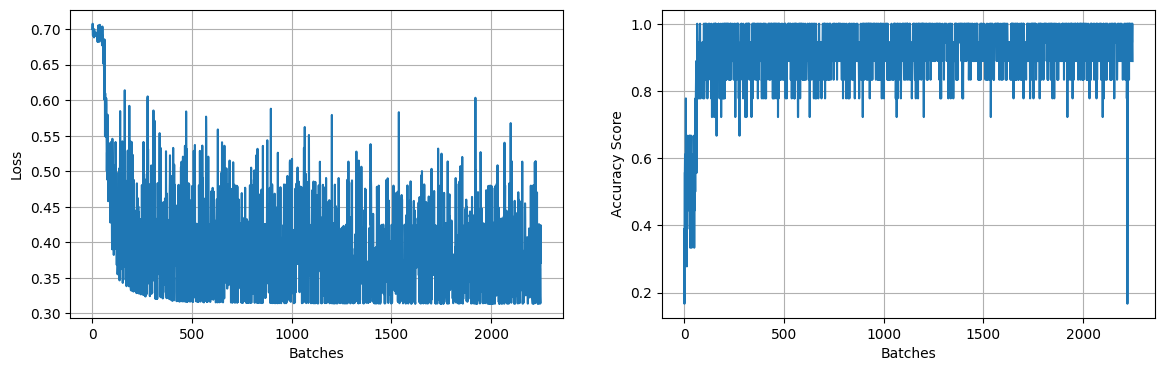

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def add_subplot(axis, metric_history, title):
  axis.plot(metric_history)
  axis.set_xlabel("Batches")
  axis.set_ylabel(title)
  axis.grid(True)

# Since each batch has 18 reviews, divide the accuracy score by 18
accuracies = [acc/18 for acc in tr_accuracies]

# Print average results
print(f"Accuracy: {np.mean(accuracies):.3f} - Loss: {np.mean(tr_losses):.3f}\n")


fig, (ax1) = plt.subplots(1,2, figsize=(14, 4))

add_subplot(axis=ax1[0], metric_history=tr_losses, title="Loss")
add_subplot(axis=ax1[1], metric_history=accuracies, title="Accuracy Score")

In [12]:
# Evaluate model on testing data
from torcheval.metrics import BinaryF1Score, BinaryPrecision, BinaryRecall

f1 = BinaryF1Score()
precision = BinaryPrecision()
recall = BinaryRecall()

testing_accuracies = []
testing_losses=[]
f1_history = []
precision_history = []
recall_history = []

num_steps=0
nb_tr_examples=0

model.eval()

with torch.no_grad():
  for index, data in enumerate(testing_loader):
    # Load batch
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
    targets = data['targets'].to(device, dtype = torch.long)

    # Predict using model
    outputs = model.forward(ids, mask, token_type_ids).squeeze()

    # Calculate testing loss
    testing_loss = loss_function(outputs, targets)
    testing_losses.append(testing_loss.item())

    # Calculate testing accuracy
    big_val, big_idx = torch.max(outputs.data, dim=1)
    testing_accuracies.append(calculate_accuracy(big_idx, targets))

    # F1 Score - Precision - Recall
    f1_score = calculate_metric(metric=f1, y_pred=big_idx, y_true=targets)
    precision_score = calculate_metric(metric=precision, y_pred=big_idx, y_true=targets)
    recall_score = calculate_metric(metric=recall, y_pred=big_idx, y_true=targets)

    f1_history.append(f1_score)
    precision_history.append(precision_score)
    recall_history.append(recall_score)

    # Metrics per batch
    num_steps += 1
    nb_tr_examples += targets.size(0)

    testing_loss_step = sum(testing_losses) / num_steps
    testing_accu_step = sum(testing_accuracies) / nb_tr_examples
    print(f"Batch {index} => loss: {testing_loss_step:.3f} - accuracy: {testing_accu_step:.3f}, recall: {recall_score:.3f} - precision: {precision_score:.3f} - f1_score: {f1_score:.3f}")

Batch 0 => loss: 0.462 - accuracy: 0.833, recall: 0.778 - precision: 0.875 - f1_score: 0.824
Batch 1 => loss: 0.388 - accuracy: 0.917, recall: 0.900 - precision: 0.947 - f1_score: 0.923
Batch 2 => loss: 0.386 - accuracy: 0.907, recall: 0.857 - precision: 0.960 - f1_score: 0.906
Batch 3 => loss: 0.368 - accuracy: 0.931, recall: 0.886 - precision: 0.969 - f1_score: 0.925
Batch 4 => loss: 0.368 - accuracy: 0.933, recall: 0.889 - precision: 0.976 - f1_score: 0.930
Batch 5 => loss: 0.360 - accuracy: 0.944, recall: 0.914 - precision: 0.981 - f1_score: 0.946
Batch 6 => loss: 0.363 - accuracy: 0.944, recall: 0.921 - precision: 0.967 - f1_score: 0.943
Batch 7 => loss: 0.357 - accuracy: 0.951, recall: 0.932 - precision: 0.972 - f1_score: 0.952
Batch 8 => loss: 0.352 - accuracy: 0.957, recall: 0.938 - precision: 0.974 - f1_score: 0.956
Batch 9 => loss: 0.348 - accuracy: 0.961, recall: 0.947 - precision: 0.978 - f1_score: 0.962
Batch 10 => loss: 0.348 - accuracy: 0.960, recall: 0.950 - precision: 

Accuracy: 0.938 - Loss: 0.372 -  Recall: 0.933 - Precision: 0.946 - F1: 0.939



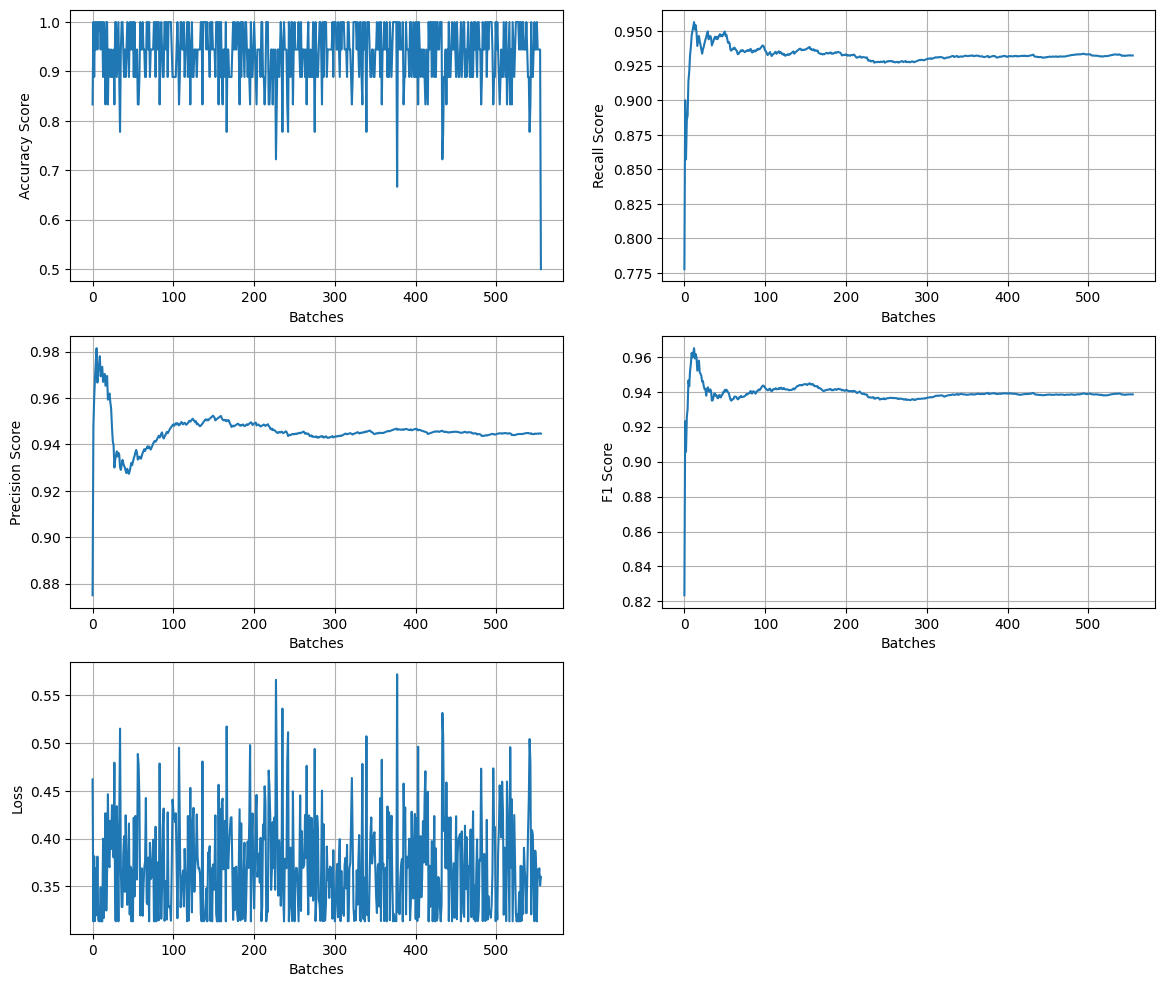

In [15]:
# Create a figure with 1 row and 2 columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,2, figsize=(14, 12))
test_accuracies = [acc/18 for acc in testing_accuracies]

# Print average results
print(f"Accuracy: {np.mean(test_accuracies):.3f} - Loss: {np.mean(testing_losses):.3f} -  Recall: {np.mean(recall_history):.3f} - Precision: {np.mean(precision_history):.3f} - F1: {np.mean(f1_history):.3f}\n")

add_subplot(axis=ax1[0], metric_history=test_accuracies, title="Accuracy Score")
add_subplot(axis=ax1[1], metric_history=recall_history, title="Recall Score")
add_subplot(axis=ax2[0], metric_history=precision_history, title="Precision Score")
add_subplot(axis=ax2[1], metric_history=f1_history, title="F1 Score")
add_subplot(axis=ax3[0], metric_history=testing_losses, title="Loss")
fig.delaxes(ax3[1])

In [13]:
torch.save(model, "drive/MyDrive/RoBERTa_GRU/RoBERTa_GRU_model.pth")
tokenizer.save_pretrained("drive/MyDrive/RoBERTa_GRU/RoBERTa_Pretrained_Tokenizer.pth")
tokenizer.save_vocabulary("drive/MyDrive/RoBERTa_GRU/")

('drive/MyDrive/RoBERTa_GRU/vocab.json',
 'drive/MyDrive/RoBERTa_GRU/merges.txt')